In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

In [26]:
train_set = torchvision.datasets.FashionMNIST(
    "./data", download=True, transform=transforms.Compose([transforms.ToTensor()])
)
test_set = torchvision.datasets.FashionMNIST(
    "./data",
    download=True,
    train=False,
    transform=transforms.Compose([transforms.ToTensor()]),
)

In [27]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100)

In [28]:
def output_label(label):
    output_mapping = {
        0: "T-shirt/Top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot",
    }
    input = label.item() if type(label) == torch.Tensor else label
    return output_mapping[input]

In [29]:
a = next(iter(train_loader))
a[0].size()

torch.Size([100, 1, 28, 28])

In [30]:
len(train_set)

60000

9


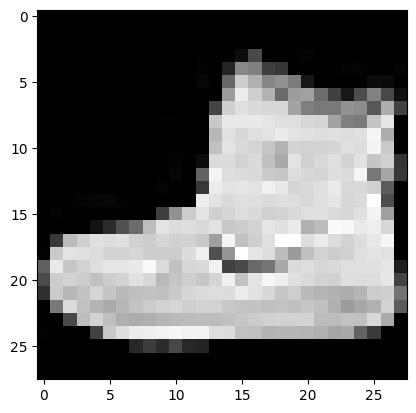

In [31]:
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

In [32]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


In [33]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


In [ ]:
class MyCNN(nn.Module):
    def __init__(self, kernel_size=2):
        super(MyCNN, self).__init__()
        self.kernel_size = kernel_size
        print("kernel size", self.kernel_size)
        input_size = 28
        output_channels_value = 3
        print("output_channels_value", output_channels_value)
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=output_channels_value,
            kernel_size=self.kernel_size,
        )
        self.pool = nn.MaxPool2d(self.kernel_size)
        conv_out_size = (input_size - self.kernel_size) + 1
        print(f"conv_out_size: {conv_out_size}")
        pool_out_size = ((conv_out_size - self.kernel_size) // self.kernel_size) + 1
        print(f"pool_out_size: {pool_out_size}")
        input_size_after_conv_and_pool = (
            output_channels_value * pool_out_size * pool_out_size
        )
        print("input_size_after_conv_and_pool", input_size_after_conv_and_pool)
        self.fc1 = nn.Linear(input_size_after_conv_and_pool, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        self.features = x
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        return x

In [34]:
class AdjustedFashionCNN(nn.Module):
    def __init__(self):
        super(AdjustedFashionCNN, self).__init__()

        # Layer 2 to 5
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=32, kernel_size=3, padding=1
            ),  # Layer 2: Convolutional layer
            nn.BatchNorm2d(32),  # Layer 3: Batch normalization
            nn.ReLU(),  # Layer 4: ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),  # Layer 5: Max Pooling
        )

        # Layer 6 to 9
        self.layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=32, out_channels=64, kernel_size=3
            ),  # Layer 6: Convolutional layer
            nn.BatchNorm2d(64),  # Layer 7: Batch normalization
            nn.ReLU(),  # Layer 8: ReLU activation
            nn.MaxPool2d(2),  # Layer 9: Max Pooling
        )

        # Layer 11
        self.fc1 = nn.Linear(in_features=64 * 6 * 6, out_features=600)

        # Layer 10: Dropout
        self.drop = nn.Dropout2d(0.25)

        # Layer 12
        self.fc2 = nn.Linear(in_features=600, out_features=120)

        # Layer 13: Classification layer
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out


# Create an instance of the adjusted model and print its architecture
adjusted_fashion_model = AdjustedFashionCNN()
adjusted_fashion_model

AdjustedFashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

In [52]:
model = AdjustedFashionCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=0.00001
)  # Using Adam optimizer with a learning rate of 0.001

# Check if GPU is available and move the model to GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

AdjustedFashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

Epoch [1/5], Train Accuracy: 72.72%, Test Accuracy: 79.44%, Train Loss: 0.9445, Test Loss: 0.5912
Epoch [2/5], Train Accuracy: 82.31%, Test Accuracy: 83.58%, Train Loss: 0.5125, Test Loss: 0.4717
Epoch [3/5], Train Accuracy: 85.20%, Test Accuracy: 85.50%, Train Loss: 0.4279, Test Loss: 0.4166
Epoch [4/5], Train Accuracy: 86.85%, Test Accuracy: 86.41%, Train Loss: 0.3820, Test Loss: 0.3838
Epoch [5/5], Train Accuracy: 87.76%, Test Accuracy: 87.20%, Train Loss: 0.3521, Test Loss: 0.3619
Training and testing completed!


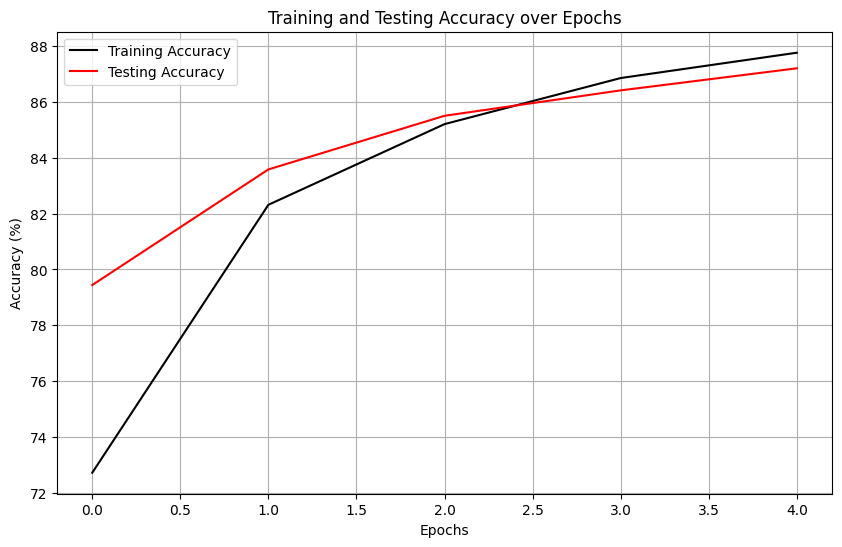

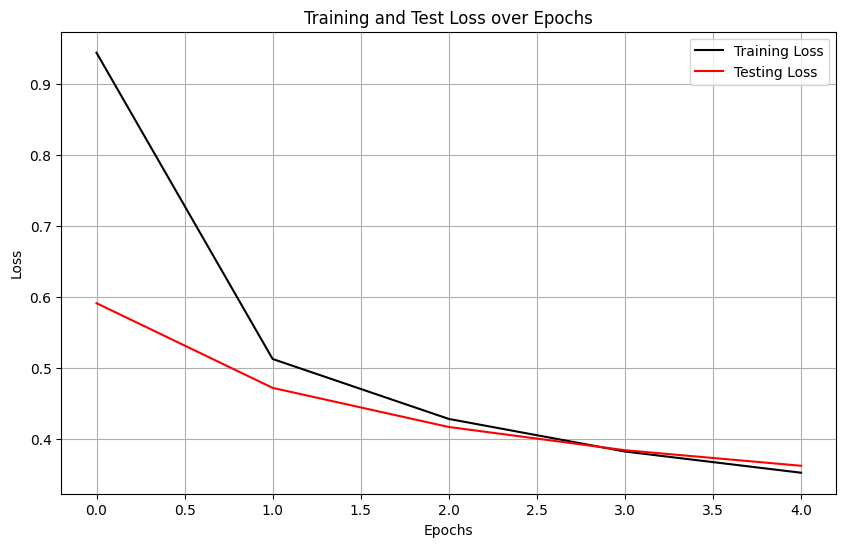

In [65]:
# Defining the train and test functions


def train(model, data_loader, criterion, optimizer):
    model.train()
    correct = 0
    total = 0
    total_loss = 0.0

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    average_loss = total_loss / len(data_loader)
    return accuracy, average_loss


def test(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    accuracy = 100 * correct / total
    average_loss = total_loss / len(data_loader)
    return accuracy, average_loss


# Model, loss function, optimizer initialization
model = AdjustedFashionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

# Training the model and capturing metrics
num_epochs = 5
train_accuracies, test_accuracies, train_losses, test_losses = [], [], [], []

for epoch in range(num_epochs):
    train_accuracy, train_loss = train(model, train_loader, criterion, optimizer)
    test_accuracy, test_loss = test(model, test_loader)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(
        f"Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}"
    )

print("Training and testing completed!")

# Visualizing the results
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, "k", label="Training Accuracy")
plt.plot(test_accuracies, "r", label="Testing Accuracy")
plt.title("Training and Testing Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(train_losses, "k", label="Training Loss")
plt.plot(test_losses, "r", label="Testing Loss")
plt.title("Training and Test Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

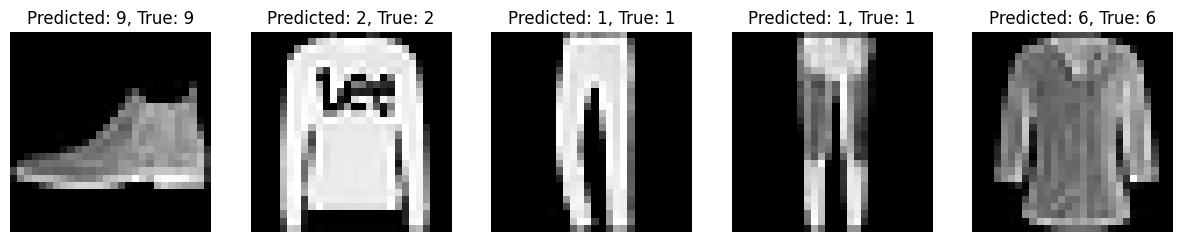

In [66]:
# Function to predict and plot
def predict_and_plot(model, data_loader, num_images=5):
    model.eval()  # Set the model to evaluation mode
    images_so_far = 0
    fig = plt.figure(figsize=(15, 7))

    with torch.no_grad():
        for i, (images, labels) in enumerate(data_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 5, 5, images_so_far)
                ax.axis("off")
                ax.set_title(f"Predicted: {preds[j]}, True: {labels[j]}")
                img = images.cpu().data[j].numpy().transpose((1, 2, 0))
                plt.imshow(img.squeeze(), cmap="gray")

                if images_so_far == num_images:
                    return


# Predict and plot using the test data
predict_and_plot(model, test_loader)

In [75]:
class AdjustedFashionCNN(nn.Module):
    def __init__(self, kernel_size=3):
        super(AdjustedFashionCNN, self).__init__()

        self.kernel_size = kernel_size
        input_size = 28  # Assuming the input images are 28x28
        output_channels1 = 32
        output_channels2 = 64

        # Compute output sizes after conv and pool operations
        conv1_out_size = input_size - self.kernel_size + 1
        pool1_out_size = (
            conv1_out_size // 2
        )  # Using kernel_size and stride=2 for pooling

        conv2_input_size = pool1_out_size
        conv2_out_size = conv2_input_size - self.kernel_size + 1
        pool2_out_size = conv2_out_size // 2

        fc_input_size = output_channels2 * pool2_out_size * pool2_out_size

        # Layer 2 to 5
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=output_channels1,
                kernel_size=self.kernel_size,
            ),  # Layer 2: Convolutional layer
            nn.BatchNorm2d(output_channels1),  # Layer 3: Batch normalization
            nn.ReLU(),  # Layer 4: ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),  # Layer 5: Max Pooling
        )

        # Layer 6 to 9
        self.layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=output_channels1,
                out_channels=output_channels2,
                kernel_size=self.kernel_size,
            ),  # Layer 6: Convolutional layer
            nn.BatchNorm2d(output_channels2),  # Layer 7: Batch normalization
            nn.ReLU(),  # Layer 8: ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),  # Layer 9: Max Pooling
        )

        # Layer 11
        self.fc1 = nn.Linear(in_features=fc_input_size, out_features=600)

        # Layer 10: Dropout
        self.drop = nn.Dropout2d(0.25)

        # Layer 12
        self.fc2 = nn.Linear(in_features=600, out_features=120)

        # Layer 13: Classification layer
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out


# Create an instance of the adjusted model with a kernel size of 3 (for example) and print its architecture
adjusted_fashion_model = AdjustedFashionCNN(kernel_size=3)
adjusted_fashion_model

AdjustedFashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1600, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


Training with kernel size: 2

Epoch [1/5], Train Accuracy: 71.61%, Test Accuracy: 78.97%, Train Loss: 0.9789, Test Loss: 0.6189
Epoch [2/5], Train Accuracy: 81.50%, Test Accuracy: 82.75%, Train Loss: 0.5347, Test Loss: 0.4984
Epoch [3/5], Train Accuracy: 84.55%, Test Accuracy: 84.43%, Train Loss: 0.4502, Test Loss: 0.4443
Epoch [4/5], Train Accuracy: 86.05%, Test Accuracy: 85.36%, Train Loss: 0.4051, Test Loss: 0.4133
Epoch [5/5], Train Accuracy: 86.93%, Test Accuracy: 86.10%, Train Loss: 0.3758, Test Loss: 0.3919
Finished Training for kernel size: 2

Training with kernel size: 3

Epoch [1/5], Train Accuracy: 69.90%, Test Accuracy: 76.99%, Train Loss: 1.0693, Test Loss: 0.6560
Epoch [2/5], Train Accuracy: 79.64%, Test Accuracy: 80.98%, Train Loss: 0.5742, Test Loss: 0.5313
Epoch [3/5], Train Accuracy: 82.61%, Test Accuracy: 83.10%, Train Loss: 0.4867, Test Loss: 0.4733
Epoch [4/5], Train Accuracy: 84.62%, Test Accuracy: 84.30%, Train Loss: 0.4367, Test Loss: 0.4381
Epoch [5/5], Train 

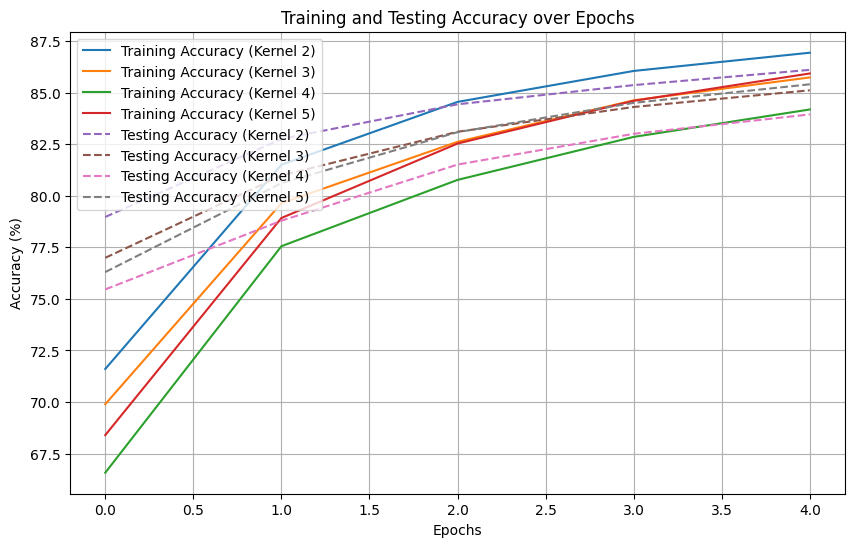

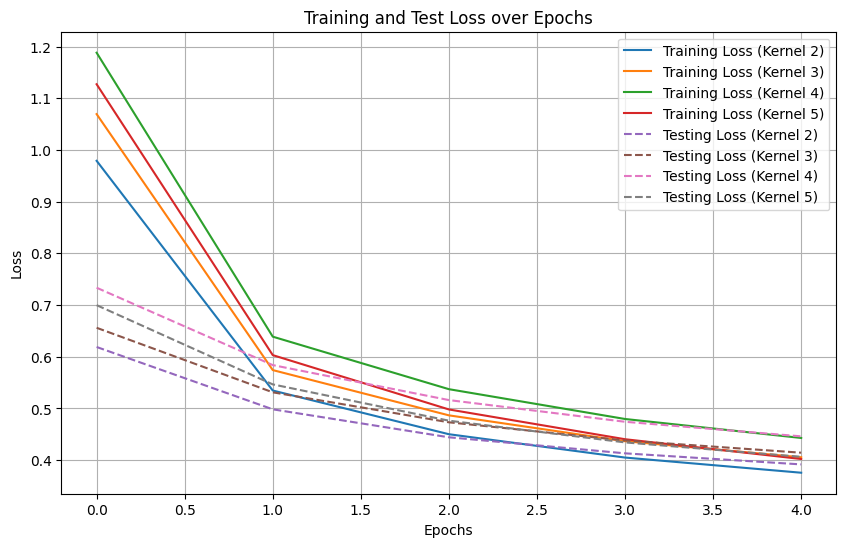

In [76]:
# List of kernel sizes to experiment with
kernelSizes = [2, 3, 4, 5]

# Initialize lists to store the overall results for each kernel size
all_train_accuracies = {}
all_test_accuracies = {}
all_train_losses = {}
all_test_losses = {}

for kernel in kernelSizes:
    print(f"\nTraining with kernel size: {kernel}\n")
    # Model, loss function, optimizer initialization for current kernel size
    model = AdjustedFashionCNN(kernel_size=kernel).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

    # Lists to store metrics for the current kernel size
    train_accuracies, test_accuracies, train_losses, test_losses = [], [], [], []

    for epoch in range(num_epochs):
        train_accuracy, train_loss = train(model, train_loader, criterion, optimizer)
        test_accuracy, test_loss = test(model, test_loader)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(
            f"Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}"
        )

    # Store the results for the current kernel size
    all_train_accuracies[kernel] = train_accuracies
    all_test_accuracies[kernel] = test_accuracies
    all_train_losses[kernel] = train_losses
    all_test_losses[kernel] = test_losses

    print("Finished Training for kernel size:", kernel)

# Visualizing the results for all kernel sizes
plt.figure(figsize=(10, 6))
for kernel, acc in all_train_accuracies.items():
    plt.plot(acc, label=f"Training Accuracy (Kernel {kernel})")
for kernel, acc in all_test_accuracies.items():
    plt.plot(acc, "--", label=f"Testing Accuracy (Kernel {kernel})")

plt.title("Training and Testing Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for kernel, loss in all_train_losses.items():
    plt.plot(loss, label=f"Training Loss (Kernel {kernel})")
for kernel, loss in all_test_losses.items():
    plt.plot(loss, "--", label=f"Testing Loss (Kernel {kernel})")

plt.title("Training and Test Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()